# Baseline Model & Previous Iteration(s) Results 

#### ROC_AUC To Beat :  0.59035

<img src="../../mesc/baseline_model/progress_1.PNG">

# Performance Bottleneck : Need good missing values imputation strategy

## Begin with imports

In [164]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt  
%matplotlib inline  
import seaborn as sns 
import plotly.express as px
import plotly.io as pio
#import cudf as cd
#import cuml
plt.style.use('fivethirtyeight')  # a popular data visualization theme
%load_ext autoreload
%autoreload 2
import importlib
import sys
sys.path.append('../../modeler/')
import ppl as pl
import viz as vz
import helper_funcs as hf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [165]:
dataset_path="../../Datasets/widsdatathon2020/training_v2.csv"
df=pd.read_csv(dataset_path)
df.head()

encounter_id  patient_id  hospital_id  hospital_death   age    bmi  \
0         66154       25312          118               0  68.0  22.73   
1        114252       59342           81               0  77.0  27.42   
2        119783       50777          118               0  25.0  31.95   
3         79267       46918          118               0  81.0  22.64   
4         92056       34377           33               0  19.0    NaN   

   elective_surgery  ethnicity gender  height  ... aids cirrhosis  \
0                 0  Caucasian      M   180.3  ...  0.0       0.0   
1                 0  Caucasian      F   160.0  ...  0.0       0.0   
2                 0  Caucasian      F   172.7  ...  0.0       0.0   
3                 1  Caucasian      F   165.1  ...  0.0       0.0   
4                 0  Caucasian      M   188.0  ...  0.0       0.0   

   diabetes_mellitus hepatic_failure immunosuppression  leukemia  lymphoma  \
0                1.0             0.0               0.0       0.0       0.0   
1                1.0             0.0               0.0       0.0       0.0   
2                0.0             0.0               0.0       0.0       0.0   
3                0.0             0.0               0.0       0.0       0.0   
4                0.0             0.0               0.0       0.0       0.0   

   solid_tumor_with_metastasis  apache_3j_bodysystem  apache_2_bodysystem  
0                          0.0                Sepsis       Cardiovascular  
1                          0.0           Respiratory          Respiratory  
2                          0.0             Metabolic            Metabolic  
3                          0.0        Cardiovascular       Cardiovascular  
4                          0.0                Trauma               Trauma  

[5 rows x 186 columns]

### Check for explicit missing values
Note : A complete data dictionary has been provided by dataset distributors which needs to be studied in detail in order to explore further dimensions of the data most importantly in the following areas
1. Missing Values being encoded in some other way
2. Even if documentation wasnot provided, we would need to still dig deeper into attributes for isnight regarding missing vales. For example, attribute "height" and "bmi" can never be zero! If for such attributes, zero is present, that implies missing values in our data!


In [166]:
missing_values_series=df.isnull().sum()
missing_columns=missing_values_series[missing_values_series>0]
missing_columns_df=(missing_columns.sort_values()/df.shape[0])*100
title="Distribution of Missing Values Pct % Vs Attributes"
x_col="Attributes"
y_col="Missing Pct %"
missing_columns_df=pd.DataFrame(data=np.column_stack([missing_columns_df.index,missing_columns_df.values]),columns=[x_col,y_col])
vz.count_plot(missing_columns_df,x=x_col,y=y_col,matplotlib_use=False,title=title)

<Figure size 3600x720 with 0 Axes>

## Insights:
1. There are columns with slightly missing values whereas some have quite a large number of missing values!
2. Dealing with missing values might lead to much higher perforrmance gains provided attribute is a valuable feature!
3. For baseline model, we dropped missing value rows and didnot employ any imputation strategy
4. Dropping missing values depends upon how much data we are left with, and above clearly shows that missing vales must be imputed!

In [167]:
## Lets check how many rows have atleast 1 missing value
print("Total # of rows in dataset : {}".format(df.shape[0]))
print("Data Frame without any missing values : {}".format(df.dropna().shape[0]))
print("Data Frame with >=1 missing value(s) : {}".format(df.shape[0]-df.dropna().shape[0]))

Total # of rows in dataset : 91713
Data Frame without any missing values : 25
Data Frame with >=1 missing value(s) : 91688


## EDA on missing values

In [168]:
missing_columns_df

Attributes Missing Pct %
0              gender     0.0272589
1    icu_admit_source       0.12212
2    d1_heartrate_max      0.158102
3    d1_heartrate_min      0.158102
4        d1_sysbp_min      0.173367
..                ...           ...
170    h1_albumin_min       91.3982
171    h1_lactate_max       91.9924
172    h1_lactate_min       91.9924
173  h1_bilirubin_max        92.265
174  h1_bilirubin_min        92.265

[175 rows x 2 columns]

## Investigate : Columns with slightly missing values whereas some have quite a large number of missing values!

In [208]:
(df[["patient_id","hospital_id","encounter_id"]]).drop_duplicates()

patient_id  hospital_id  encounter_id
0           25312          118         66154
1           59342           81        114252
2           50777          118        119783
3           46918          118         79267
4           34377           33         92056
...           ...          ...           ...
91708       78108           30         91592
91709       13486          121         66119
91710       58179          195          8981
91711      120598           66         33776
91712       53612          104          1671

[91713 rows x 3 columns]

In [170]:
missing_columns_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175 entries, 0 to 174
Data columns (total 2 columns):
Attributes       175 non-null object
Missing Pct %    175 non-null object
dtypes: object(2)
memory usage: 2.9+ KB


In [171]:
out,bins=pd.cut(missing_columns_df["Missing Pct %"],bins=5,retbins=True)
missing_columns_df["bins"]=out
missing_columns_df

Attributes Missing Pct %              bins
0              gender     0.0272589  (-0.065, 18.475]
1    icu_admit_source       0.12212  (-0.065, 18.475]
2    d1_heartrate_max      0.158102  (-0.065, 18.475]
3    d1_heartrate_min      0.158102  (-0.065, 18.475]
4        d1_sysbp_min      0.173367  (-0.065, 18.475]
..                ...           ...               ...
170    h1_albumin_min       91.3982  (73.817, 92.265]
171    h1_lactate_max       91.9924  (73.817, 92.265]
172    h1_lactate_min       91.9924  (73.817, 92.265]
173  h1_bilirubin_max        92.265  (73.817, 92.265]
174  h1_bilirubin_min        92.265  (73.817, 92.265]

[175 rows x 3 columns]

In [84]:
for key, value in missing_columns_df.groupby("bins").groups.items():
    #print(key)
    #print(value)
    temp_df=missing_columns_df.iloc[value]
    #print(temp_df)
    title="Distribution for Bin : "+str(key)
    vz.count_plot(temp_df,x="Attributes",y="Missing Pct %",matplotlib_use=False,title=title)
    #vz.plot_pie(temp_df,"Attributes","Missing_Pct %")
    #break

<Figure size 3600x720 with 0 Axes>

<Figure size 3600x720 with 0 Axes>

<Figure size 3600x720 with 0 Axes>

<Figure size 3600x720 with 0 Axes>

<Figure size 3600x720 with 0 Axes>

In [96]:
df.drop(["encounter_id","patient_id","hospital_id"],axis=1,inplace=True)

In [172]:
missing_columns_df[missing_columns_df["Missing Pct %"]>0.8]

Attributes Missing Pct %              bins
25          heart_rate_apache      0.957334  (-0.065, 18.475]
26                 map_apache       1.08382  (-0.065, 18.475]
27   d1_sysbp_noninvasive_min        1.1198  (-0.065, 18.475]
28   d1_sysbp_noninvasive_max        1.1198  (-0.065, 18.475]
29          gcs_unable_apache        1.1307  (-0.065, 18.475]
..                        ...           ...               ...
170            h1_albumin_min       91.3982  (73.817, 92.265]
171            h1_lactate_max       91.9924  (73.817, 92.265]
172            h1_lactate_min       91.9924  (73.817, 92.265]
173          h1_bilirubin_max        92.265  (73.817, 92.265]
174          h1_bilirubin_min        92.265  (73.817, 92.265]

[150 rows x 3 columns]

In [173]:
df.columns

Index(['encounter_id', 'patient_id', 'hospital_id', 'hospital_death', 'age',
       'bmi', 'elective_surgery', 'ethnicity', 'gender', 'height',
       ...
       'aids', 'cirrhosis', 'diabetes_mellitus', 'hepatic_failure',
       'immunosuppression', 'leukemia', 'lymphoma',
       'solid_tumor_with_metastasis', 'apache_3j_bodysystem',
       'apache_2_bodysystem'],
      dtype='object', length=186)

In [174]:
df.h1_lactate_min.value_counts()

1.00     279
1.20     269
1.10     257
0.90     240
1.30     240
        ... 
7.76       1
4.94       1
14.30      1
3.97       1
7.95       1
Name: h1_lactate_min, Length: 536, dtype: int64

In [209]:
df.h1_albumin_max.fillna(0,inplace=True)
df.h1_albumin_min.fillna(0,inplace=True)

In [212]:
np.sum(df.h1_albumin_max==df.h1_albumin_min)

91676

In [217]:
mask=df.h1_diasbp_max!=df.h1_diasbp_min
np.sum(mask)
df.h1_diasbp_max[mask].value_counts()

70.0     1498
74.0     1495
68.0     1492
72.0     1440
66.0     1417
         ... 
138.0      33
39.0       31
140.0      29
141.0      29
142.0      28
Name: h1_diasbp_max, Length: 107, dtype: int64

In [213]:
df[df.h1_diasbp_max!=df.h1_diasbp_max].value_counts()#["patient_id"].value_counts()

AttributeError: 'DataFrame' object has no attribute 'value_counts'

In [221]:
a="h1_mbp_invasive_max"
b="h1_mbp_invasive_min"
df.dropna(inplace=True)
ids_exist=df[df[a]==df[b]][[a,b,"patient_id"]]["patient_id"]
ids_not_exists=df[df[a]!=df[b]][[a,b,"patient_id"]]["patient_id"]
df[df[a]!=df[b]][[a,b,"patient_id"]]

h1_mbp_invasive_max  h1_mbp_invasive_min  patient_id
8286                 166.0                105.0        9930
8492                 148.0                140.0       22503
8717                  65.0                 49.0       82369
8727                 108.0                 57.0       95246
9235                 105.0                103.0       21614
9585                  87.0                 61.0       35049
10228                 76.0                 66.0       38347
17433                 57.0                 56.0       19629
31979                 70.0                 52.0       97656
34109                 88.0                 75.0      110122
35624                 87.0                 79.0      109525
41288                131.0                 96.0      104757
41618                244.0                 86.0       66907
41834                118.0                 83.0      120673
42198                136.0                 49.0      126639
42242                 84.0                 74.0       98462
43524                 81.0                 67.0       75754
52032                108.0                 90.0      108681
90317                 84.0                 76.0       20929

In [201]:
df.iloc[2].h1_lactate_max!=df.iloc[2].h1_lactate_max

True

In [191]:
a="h1_lactate_min"
b="h1_lactate_max"
ids_exist=df[df[a]==df[b]][[a,b,"patient_id"]]["patient_id"]
ids_not_exists=df[df[a]!=df[b]][[a,b,"patient_id"]]["patient_id"]


In [194]:
ids_exist

1         59342
8         10577
73        43161
106       38202
161      119419
          ...  
91654    126853
91659     52082
91692     56872
91696     20726
91703    128056
Name: patient_id, Length: 6886, dtype: int64

In [193]:
len(set(ids_not_exists).intersection(ids_exist))

0

In [202]:
(np.sum(df.h1_albumin_max==df.h1_albumin_min)/df.shape[0])*100

8.561490737409091

In [144]:
len(set(df.h1_lactate_max.value_counts().index).intersection(set(df.h1_lactate_min.value_counts().index)))

507

['h1_albumin_max', 'h1_albumin_min', 'h1_lactate_max', 'h1_lactate_min', 'h1_bilirubin_max', 'h1_bilirubin_min', 'hospital_death']


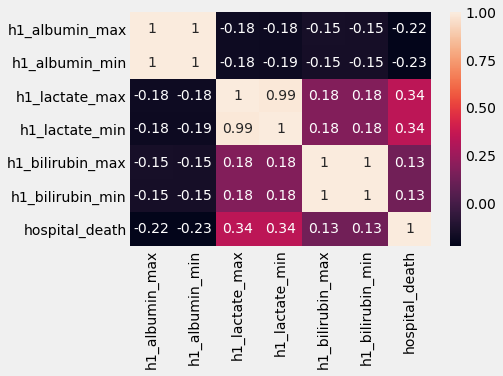

In [150]:
columns=(missing_columns_df[missing_columns_df["Missing Pct %"]>=90]).Attributes.tolist()
columns+=["hospital_death"]
print(columns)
sns.heatmap(df[columns].corr(),annot=True)

In [109]:
np.sum(df.d1_albumin_min==0)

0

In [102]:
for col in (df[df.d1_glucose_max==df.d1_glucose_max]).columns:#).apply(df.apply(pd.Series.value_counts))#value_counts()#.drop_duplicates()
        print(df[df.d1_glucose_max==df.d1_glucose_max][col].value_counts())
    

0    78454
1     7452
Name: hospital_death, dtype: int64
67.0    2149
68.0    2048
71.0    2029
72.0    2009
65.0    1945
        ... 
20.0     306
19.0     296
18.0     223
17.0     105
16.0      39
Name: age, Length: 74, dtype: int64
14.844926    402
67.814990    397
24.017768     81
24.208110     76
22.606103     75
            ... 
26.398892      1
30.132521      1
45.478684      1
27.682840      1
40.000000      1
Name: bmi, Length: 33693, dtype: int64
0    69805
1    16101
Name: elective_surgery, dtype: int64
Caucasian           66144
African American     8909
Other/Unknown        4158
Hispanic             3627
Asian                1075
Native American       765
Name: ethnicity, dtype: int64
M    46506
F    39386
Name: gender, dtype: int64
167.60    5020
177.80    4941
160.00    4905
172.70    4544
165.10    4454
          ... 
152.80       1
181.61       1
186.20       1
153.20       1
165.70       1
Name: height, Length: 395, dtype: int64
Emergency Department    34047
Operating

50.0    3248
51.0    2905
52.0    2716
46.0    2681
55.0    2669
        ... 
14.0      83
87.0      79
88.0      76
86.0      73
89.0      69
Name: d1_diasbp_min, Length: 78, dtype: int64
80.0     1935
84.0     1933
83.0     1903
88.0     1902
86.0     1889
         ... 
157.0      30
159.0      30
161.0      27
163.0      24
164.0      21
Name: d1_diasbp_noninvasive_max, Length: 120, dtype: int64
50.0    3212
51.0    2875
52.0    2694
55.0    2656
53.0    2641
        ... 
14.0      81
87.0      79
88.0      76
86.0      73
89.0      69
Name: d1_diasbp_noninvasive_min, Length: 78, dtype: int64
100.0    1881
96.0     1871
90.0     1825
98.0     1822
92.0     1816
         ... 
174.0      38
171.0      35
175.0      33
173.0      32
176.0      30
Name: d1_heartrate_max, Length: 120, dtype: int64
60.0     3149
70.0     2818
68.0     2454
62.0     2374
64.0     2326
         ... 
147.0       1
160.0       1
155.0       1
152.0       1
7.0         1
Name: d1_heartrate_min, Length: 153, dt

16.0     8439
14.0     7361
18.0     6914
12.0     6360
15.0     6107
         ... 
105.0       1
127.0       1
87.0        1
78.0        1
85.0        1
Name: h1_resprate_min, Length: 90, dtype: int64
100.0    34292
99.0     12011
98.0     10591
97.0      8390
96.0      6247
         ...  
43.0         1
50.0         1
55.0         1
12.0         1
13.0         1
Name: h1_spo2_max, Length: 72, dtype: int64
100.0    13660
97.0      9078
98.0      9076
96.0      8699
99.0      8201
         ...  
26.0         1
34.0         1
13.0         1
36.0         1
11.0         1
Name: h1_spo2_min, Length: 100, dtype: int64
132.0    309
126.0    294
124.0    287
120.0    283
130.0    281
        ... 
237.0      2
223.0      2
227.0      2
244.0      2
242.0      1
Name: h1_sysbp_invasive_max, Length: 181, dtype: int64
110.0    287
92.0     284
98.0     281
112.0    277
94.0     276
        ... 
37.0       2
44.0       2
43.0       2
32.0       1
35.0       1
Name: h1_sysbp_invasive_min, Length: 1

173.0    450
168.0    449
170.0    447
176.0    447
161.0    440
        ... 
551.0      2
511.0      2
548.0      2
532.0      2
537.0      2
Name: d1_platelets_min, Length: 540, dtype: int64
4.00    6240
4.10    6240
4.20    6020
3.90    5748
4.30    5311
        ... 
5.05       1
4.01       1
3.55       1
3.86       1
3.78       1
Name: d1_potassium_max, Length: 99, dtype: int64
3.90    6344
3.80    6275
4.00    6095
3.70    5805
4.10    5618
        ... 
3.28       1
3.55       1
3.85       1
3.62       1
3.95       1
Name: d1_potassium_min, Length: 115, dtype: int64
139.0    8453
140.0    8393
138.0    7864
141.0    7411
137.0    6733
         ... 
132.6       1
142.5       1
133.2       1
144.5       1
145.9       1
Name: d1_sodium_max, Length: 70, dtype: int64
139.0    8377
138.0    8366
137.0    7712
140.0    7650
136.0    6584
         ... 
127.2       1
148.5       1
129.7       1
130.2       1
132.1       1
Name: d1_sodium_min, Length: 137, dtype: int64
10.20    562
8.40    

38.0    997
37.0    952
35.0    944
36.0    932
39.0    848
       ... 
66.2      1
73.6      1
77.5      1
65.5      1
68.6      1
Name: d1_arterial_pco2_min, Length: 669, dtype: int64
7.400    1273
7.380    1225
7.390    1211
7.410    1184
7.420    1153
         ... 
7.093       1
7.083       1
7.148       1
7.607       1
7.192       1
Name: d1_arterial_ph_max, Length: 524, dtype: int64
7.350    1019
7.360    1001
7.340     995
7.380     952
7.320     946
         ... 
6.936       1
7.545       1
7.557       1
7.536       1
7.555       1
Name: d1_arterial_ph_min, Length: 622, dtype: int64
82.0     231
81.0     222
88.0     220
78.0     205
77.0     204
        ... 
169.1      1
210.5      1
173.6      1
389.8      1
249.7      1
Name: d1_arterial_po2_max, Length: 2415, dtype: int64
71.0     396
77.0     393
69.0     388
70.0     374
67.0     372
        ... 
265.3      1
39.4       1
292.6      1
211.7      1
184.8      1
Name: d1_arterial_po2_min, Length: 1810, dtype: int64
250.0000

In [232]:
!pip install bubbly

  Created wheel for bubbly: filename=bubbly-1.0.2-cp37-none-any.whl size=5433 sha256=fcf8c47dfda034b34169831a096a7d4789608b95e634ea12b055bd86b201db62
  Stored in directory: C:\Users\Aisha Javed\AppData\Local\pip\Cache\wheels\cf\3c\75\8c09dbf7cd6b320b69a6bc679fd111abd1139866c722b1476b
Successfully built bubbly


In [234]:
from bubbly.bubbly import make_grid_with_categories

# Define the new variable
category_column = 'Attributes'
x_column="Attrib"

# Make the grid
dataset=missing_columns_df
#years = dataset[time_column].unique()
category_column="Attributes"
continents = dataset[category_column].unique()
col_name_template = '{}+{}+{}_grid'
column_names = [x_column, y_column, bubble_column, size_column]
grid = make_grid_with_categories(dataset, column_names, time_column, 
                                 category_column, years, continents)
    
# Set the layout
figure, sliders_dict = set_layout(x_title='GDP per Capita', y_title='Life Expectancy', 
            title='Gapminder Global Indicators', x_logscale=True, y_logscale=False, 
            show_slider=True, slider_scale=years, show_button=True, show_legend=False, height=650)

# Add the base frame
year = min(years)
col_name_template_year = col_name_template.format(year, {}, {})
for continent in continents:
    trace = get_trace(grid=grid, col_name_template=col_name_template_year, 
                    x_column=x_column, y_column=y_column, 
                    bubble_column=bubble_column, size_column=size_column, category=continent)
    figure['data'].append(trace)

# Add time frames
for year in years:
    frame = {'data': [], 'name': str(year)}
    col_name_template_year = col_name_template.format(year, {}, {})
    for continent in continents:
        trace = get_trace(grid=grid, col_name_template=col_name_template_year, 
                    x_column=x_column, y_column=y_column, 
                    bubble_column=bubble_column, size_column=size_column, category=continent)
        frame['data'].append(trace)

    figure['frames'].append(frame) 
    add_slider_steps(sliders_dict, year)

# Set the layout once more
figure['layout']['xaxis']['autorange'] = True
figure['layout']['yaxis']['range'] = [20, 100]
figure['layout']['showlegend'] = True
figure['layout']['sliders'] = [sliders_dict]

# Plot the animation
iplot(figure, config={'scrollzoom': True})

NameError: name 'x_column' is not defined

## Check class distribution

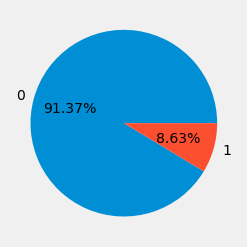

In [29]:
vz.plot_pie(df,"hospital_death","Class Distribution") #plt.plot(kind="pie",data=df["hospital_death"])

### Class imbalance is yet another issue!

## Luckily, we have been provided datatypes of each variable. Lets use that for EDA of missing values

In [12]:
data_dict_path="../../Datasets/widsdatathon2020/WiDS Datathon 2020 Dictionary.csv"
data_dict_df=pd.read_csv(data_dict_path)

In [15]:
include_columns=[col for col in non_missing_df.columns if "id" not in col]
non_missing_df_fixed=non_missing_df_fixed[include_columns]
non_missing_df_fixed.columns

Index(['hospital_death', 'elective_surgery', 'icu_stay_type', 'icu_type',
       'pre_icu_los_days', 'readmission_status', 'apache_post_operative'],
      dtype='object')

### Descriptive Statistics

In [242]:
non_missing_df_fixed.dtypes

hospital_death              bool
elective_surgery            bool
icu_stay_type             object
icu_type                  object
pre_icu_los_days         float64
readmission_status          bool
apache_post_operative       bool
dtype: object

## Above shows all categorical attributes apart from pre_icu_loss_days

### Check for duplicates in original dataset and selected subset of dataset against 6 columns

In [17]:
feat_cols=['elective_surgery', 'icu_stay_type', 'icu_type',\
       'pre_icu_los_days', 'readmission_status', 'apache_post_operative']
pred_column="hospital_death"
non_missing_df_fixed_unique=non_missing_df_fixed.drop_duplicates(subset=feat_cols,keep=False)
print("Total Rows in df read from file : {}".format(df.shape))
print("Total Unique Rows in df read from file : {}".format(df.drop_duplicates(keep=False).shape))
print("Total Rows of df against SELECTED SUBSET of 6 non missing columns : {}".format(non_missing_df_fixed.shape))
print("Total Unique Rows of df against selected subset of non missing columns : {}".format(non_missing_df_fixed_unique.shape))
print("% of dataset examples to be used for learning : {}% only".format(int((non_missing_df_fixed_unique.shape[0]/df.shape[0])*100)))

Total Rows in df read from file : (91713, 186)
Total Unique Rows in df read from file : (91713, 186)
Total Rows of df against SELECTED SUBSET of 6 non missing columns : (91713, 7)
Total Unique Rows of df against selected subset of non missing columns : (19438, 7)
% of dataset examples to be used for learning : 21% only


## Dataset Issues!
2. We would be learning from 20% of dataset only which means performance would most probably be very low unless we are lucky that the subset of attributes selected consisted of only features!

Insight to validity of above can be provided through following
1. check correlation of other columns with label & check if significant columns of higher correlations are not being included at this stage
2. change in distribution of label


## Correlation

In [18]:
import seaborn as sns
corr_matrix=df.corr()
corr_matrix

encounter_id  patient_id  hospital_id  \
encounter_id                     1.000000   -0.009575    -0.004532   
patient_id                      -0.009575    1.000000    -0.007075   
hospital_id                     -0.004532   -0.007075     1.000000   
hospital_death                  -0.005243    0.004877    -0.001255   
age                             -0.003990    0.006343    -0.008673   
...                                   ...         ...          ...   
hepatic_failure                 -0.000972   -0.001667     0.001362   
immunosuppression               -0.001707    0.000548     0.000146   
leukemia                        -0.002172    0.000844    -0.002992   
lymphoma                        -0.001176    0.002333     0.002588   
solid_tumor_with_metastasis     -0.004646   -0.003065    -0.004730   

                             hospital_death       age       bmi  \
encounter_id                      -0.005243 -0.003990 -0.001068   
patient_id                         0.004877  0.006343 -0.001380   
hospital_id                       -0.001255 -0.008673  0.012874   
hospital_death                     1.000000  0.111017 -0.031247   
age                                0.111017  1.000000 -0.087077   
...                                     ...       ...       ...   
hepatic_failure                    0.038864 -0.020061 -0.001855   
immunosuppression                  0.043973  0.025007 -0.031144   
leukemia                           0.029788  0.030310 -0.013375   
lymphoma                           0.018722  0.023335 -0.010017   
solid_tumor_with_metastasis        0.051105  0.025924 -0.043380   

                             elective_surgery    height    icu_id  \
encounter_id                         0.002036 -0.005400 -0.000992   
patient_id                           0.001387  0.002902 -0.001770   
hospital_id                          0.052123  0.027895  0.004526   
hospital_death                      -0.093574 -0.019526  0.000994   
age                                  0.067320 -0.109937 -0.024257   
...                                       ...       ...       ...   
hepatic_failure                     -0.034700  0.010481 -0.011746   
immunosuppression                   -0.014695  0.000530 -0.031111   
leukemia                            -0.017587  0.001718  0.001014   
lymphoma                            -0.008215  0.008370 -0.002336   
solid_tumor_with_metastasis          0.015369  0.004921 -0.014381   

                             pre_icu_los_days  ...  \
encounter_id                        -0.000570  ...   
patient_id                          -0.004412  ...   
hospital_id                         -0.001285  ...   
hospital_death                       0.063316  ...   
age                                  0.049872  ...   
...                                       ...  ...   
hepatic_failure                      0.015063  ...   
immunosuppression                    0.032695  ...   
leukemia                             0.041853  ...   
lymphoma                             0.013954  ...   
solid_tumor_with_metastasis          0.036581  ...   

                             apache_4a_hospital_death_prob  \
encounter_id                                     -0.000513   
patient_id                                        0.003735   
hospital_id                                      -0.006993   
hospital_death                                    0.311043   
age                                               0.143167   
...                                                    ...   
hepatic_failure                                   0.024115   
immunosuppression                                 0.038922   
leukemia                                          0.044126   
lymphoma                                          0.018303   
solid_tumor_with_metastasis                       0.048300   

                             apache_4a_icu_death_prob      aids  cirrhosis  \
encounter_id                                 0.000344  0.001907   0.007601   
pati

In [19]:
title="Correlation of Columns with Label : Hospital Death"
figsize=(10,20)
vz.count_plot(corr_matrix.loc["hospital_death"].sort_values(),x="Columns",y="Corr",matplotlib_use=False,title=title,figsize=figsize)

<Figure size 720x1440 with 0 Axes>

## Lets visualise with varrying thresholds

In [20]:
threshs=[0.1,0.2,0.3,0.4,0.5,0.6,0.0]
for thresh in threshs:
    vz.viz_corr(corr_matrix.abs(),thresh=thresh)

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

## Encoding of categorical attributes of selected dataframe before checking correlations and outliers presence

In [21]:
non_missing_df_fixed=non_missing_df_fixed_unique

In [22]:
non_missing_df_fixed.columns

Index(['hospital_death', 'elective_surgery', 'icu_stay_type', 'icu_type',
       'pre_icu_los_days', 'readmission_status', 'apache_post_operative'],
      dtype='object')

### lets check correlation

In [270]:
figsize=(1,1)
for col in corr_copy.columns:
    if col=="hospital_death" or col=="pre_icu_los_days":continue
    """print(col)
    print(corr_copy[col].value_counts())
    print("***********")"""
    title="Counts Distrubution For : "+col
    vz.count_plot(corr_copy[col].value_counts(),x="Unique Values",y="Counts",matplotlib_use=False,title=title,figsize=figsize)

<Figure size 72x72 with 0 Axes>

<Figure size 72x72 with 0 Axes>

<Figure size 72x72 with 0 Axes>

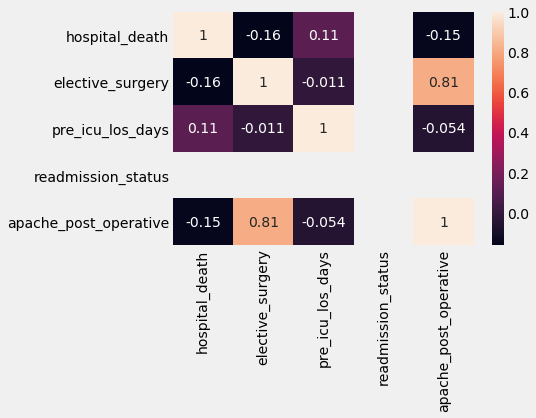

In [257]:
num_atts=[col for col in non_missing_df_fixed.columns if "type" not in col]
corr_copy=non_missing_df_fixed[num_atts].copy()
sns.heatmap(corr_copy.corr(),annot=True)

## Description of attribute ICU Stay Type has not been provided in dict dtypes - worth investigating!

In [23]:
title="ICU Stay Type"
vz.count_plot(non_missing_df_fixed["icu_stay_type"].value_counts(),x="Categories",y="Counts",matplotlib_use=False,title=title,figsize=figsize)

<Figure size 720x1440 with 0 Axes>

In [24]:
title="ICU Type"
vz.count_plot(non_missing_df_fixed["icu_type"].value_counts(),x="Categories",y="Counts",matplotlib_use=False,title=title,figsize=figsize)

<Figure size 720x1440 with 0 Axes>

In [25]:
non_missing_df_fixed=non_missing_df_fixed_unique

In [27]:


from sklearn.preprocessing import MinMaxScaler,StandardScaler


from dask.distributed import Client
client = Client(processes=False, threads_per_worker=4,
                n_workers=8, memory_limit='12GB')

from sklearn.externals import joblib

D:\Anaconda_3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning:

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.



In [28]:
non_missing_df_fixed.dtypes

hospital_death              bool
elective_surgery            bool
icu_stay_type             object
icu_type                  object
pre_icu_los_days         float64
readmission_status          bool
apache_post_operative       bool
dtype: object

## Drop readmission status col as it doesnot have any desc values

In [274]:
non_missing_df_fixed.drop("readmission_status",axis=1,inplace=True)
non_missing_df_fixed.shape

(19438, 6)

In [276]:
cat_feats,bool_feats,num_feats=hf.desc_feats(non_missing_df_fixed.drop(["hospital_death"],axis=1))
label="hospital_death"
print(bool_feats)
print(cat_feats)
print(num_feats)

['elective_surgery', 'apache_post_operative']
['icu_type', 'icu_stay_type']
['pre_icu_los_days']


## Lets Train benchmark model!

In [277]:
# your scikit-learn code

baseline_model_df=non_missing_df_fixed
rows=baseline_model_df.shape[0]
rows_pct=np.abs((baseline_model_df.shape[0]/df.shape[0])*100)
rows_pct=float("{:.2f}".format(rows_pct))
print("# of Dataset rows being used for train & test : {}".format(rows))
print("% of Dataset being used for train & test : {}%".format(rows_pct))
k_list=list(range(int(math.sqrt(rows)/2),100,2))
modeler=pl.ModelerPipeline(baseline_model_df,label,num_feats,cat_feats,knn_list=k_list)
modeler.fit() #fit the model
#modeler.predict()

# of Dataset rows being used for train & test : 19438
% of Dataset being used for train & test : 21.19%
(14578, 12)
(14578,)
0.6870934959349593 {'clf__n_neighbors': 99}
Fit Success


In [281]:
k_list

[69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99]

## Get Predictions!

Test Set Transformation Done (4860, 12)

 ******** roc_auc : 0.7201344633406749 ********


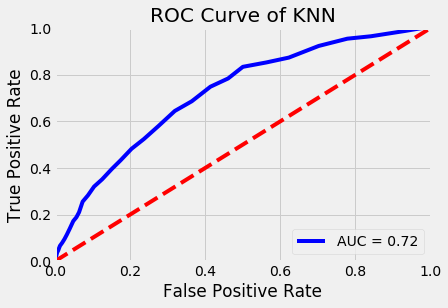

In [282]:
error,y_preds,y_scores=modeler.predict()

## 0.72 AUC for benchmark is not bad at all considering that only 20% of dataset with only 6 columns were used!

## Lets predict for Kaggle Test Set!

In [206]:
test_path="../../Datasets/widsdatathon2020/unlabeled.csv"
df_test=pd.read_csv(test_path)

## better check once that there aree no missing values for subset of columns selected

In [283]:
feat_cols=non_missing_df_fixed.columns
feat_cols

Index(['hospital_death', 'elective_surgery', 'icu_stay_type', 'icu_type',
       'pre_icu_los_days', 'apache_post_operative'],
      dtype='object')

In [284]:
df_test[feat_cols].isna().sum()

hospital_death           39308
elective_surgery             0
icu_stay_type                0
icu_type                     0
pre_icu_los_days             0
apache_post_operative        0
dtype: int64

## Another important point to note : check how many unique values of test set exist considering the feature subset that we have right now

In [285]:
unique_test_set=df_test[feat_cols].drop_duplicates(subset=feat_cols,keep=False)
print("Total Test Set Shape: {}".format(df_test.shape))
print("Actual Values of Test being Predicted : {}".format(unique_test_set.shape))
print("% of Unique Test being Predicted : {}".format(unique_test_set.shape[0]/df_test.shape[0]))


Total Test Set Shape: (39308, 186)
Actual Values of Test being Predicted : (9768, 6)
% of Unique Test being Predicted : 0.24849903327566908


## We are predicting only 24% of test set! so performance is bound to be low at this moment and this also reveals we will need more features in order to predict uniquely for test set !

In [286]:
error,y_preds,y_scores=modeler.predict(df_test=df_test,model_name="baseline_model.csv")

Test Set Transformation Done (39308, 12)
Predictions Generated & Saved : ../../predictions/baseline_model.csv


## Kaggle Submission

<img src="../../mesc/baseline_model/baseline_model_submission.PNG">

<img src="../../mesc/baseline_model/baseline_model_submission_2.PNG">